In [1]:
import numpy as np
import scipy
import scipy.signal

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

from simulate_whipple_benchmark import simulate

In [ ]:
# run cell for interactive plots
import mpld3
mpld3.enable_notebook()

In [2]:
# simulate Whipple bicycle model in the unstable capsize mode
# use non-zero initial state
x0 = np.array([1, 2, 0, 0]) * np.pi/180
x0 = np.reshape(x0, (4, 1))
g = 9.81
v = 7
dt = 0.001
simtime = 3 # seconds5555
n = int(simtime/dt)
x = simulate(v, x0, dt, n)
x = np.hstack((x0, x))
t = np.array(range(n + 1))*dt

(0, 3.0)

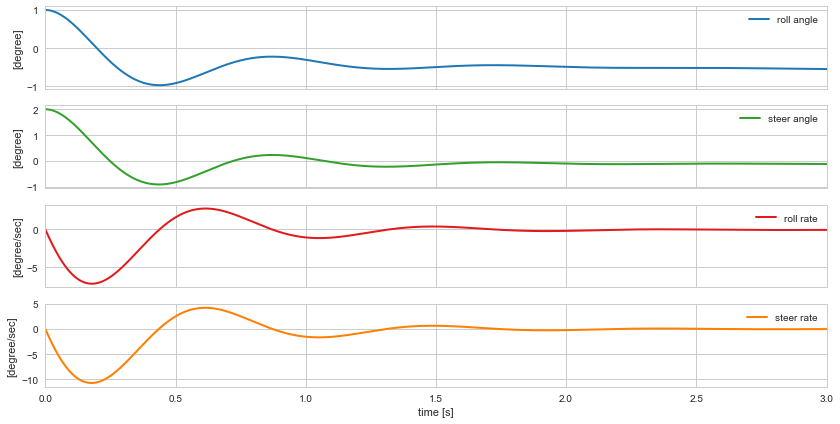

In [3]:
colors = np.roll(sns.color_palette('Paired', 12), 0, axis=0)
labels = [
    r'roll angle',
    r'steer angle',
    r'roll rate',
    r'steer rate',
    ]
ylabels = [
    r'[degree]',
    r'[degree]',
    r'[degree/sec]',
    r'[degree/sec]',
]

figsize = (14, 7)
lw = 2

fig1, ax1 = plt.subplots(4, 1, sharex=True, figsize=figsize)
for i, ax in enumerate(ax1):
    ax.plot(t, 180/np.pi * x[i, :],
            label=labels[i],
            color=colors[2*i + 1], linewidth=lw)
    ax.set_ylabel(ylabels[i])
    ax.legend()
ax1[-1].set_xlabel('time [s]')
ax1[0].set_xlim(0, max(t))

(0, 3.0)

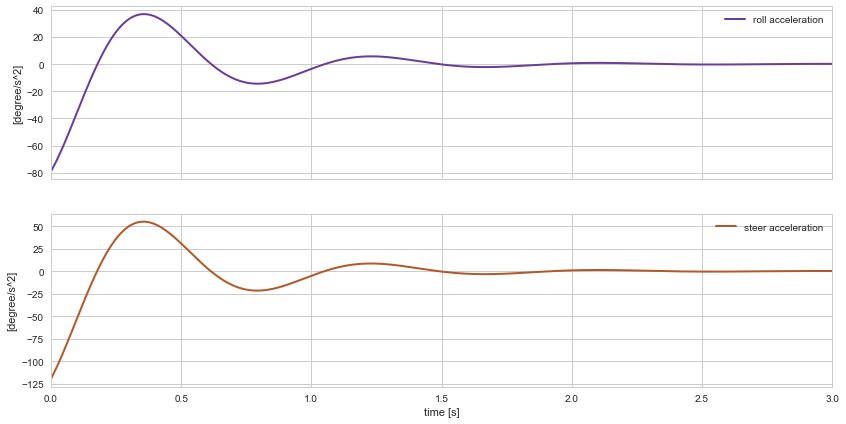

In [4]:
# calculate roll and steer acceleration using state matrix
from dtk.bicycle import benchmark_state_space_vs_speed, benchmark_matrices
_, A, B = benchmark_state_space_vs_speed(*benchmark_matrices(), [v])
A = np.squeeze(A)
B = np.squeeze(B)
dx = np.dot(A, x)

accel = dx[2:, :]

# plot accelerations
fig2, ax2 = plt.subplots(2, 1, sharex=True, figsize=figsize)
ax2[0].plot(t, 180/np.pi * accel[0, :],
            label='roll acceleration',
            color=colors[9], linewidth=lw)
ax2[0].set_ylabel('[degree/s^2]')
ax2[0].legend()
ax2[1].plot(t, 180/np.pi * accel[1, :],
            label='steer acceleration',
            color=colors[11], linewidth=lw)
ax2[1].set_ylabel('[degree/s^2]')
ax2[1].legend()
ax2[1].set_xlabel('time [s]')
ax2[1].set_xlim(0, max(t))

(0, 3.0)

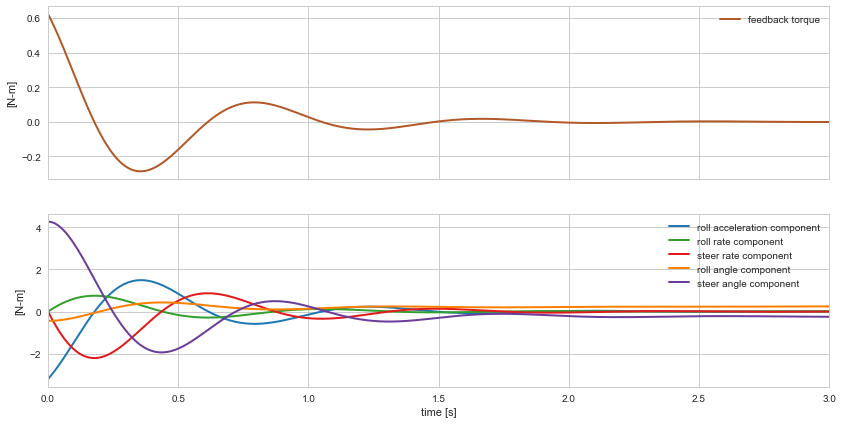

In [5]:
# calculate handlebar feedback torque using Arend's method
M, C1, K0, K2 = benchmark_matrices()
C = v*C1
K = g*K0 + v*v*K2
T_M = (M[1, 0]*accel[0, :] +
       C[1, 0]*x[2, :] +
       C[1, 1]*x[3, :] +
       K[1, 0]*x[0, :] +
       K[1, 1]*x[1, :])
fig3, ax3 = plt.subplots(2, 1, sharex=True, figsize=figsize)
ax3[0].plot(t, T_M,
            label='feedback torque',
            color=colors[11], linewidth=lw)
ax3[0].set_ylabel('[N-m]')
ax3[0].legend()
ax3[1].plot(t, M[1, 0]*accel[0, :],
            label='roll acceleration component',
            color=colors[1], linewidth=lw)
ax3[1].plot(t, C[1, 0]*x[2, :],
            label='roll rate component',
            color=colors[3], linewidth=lw)
ax3[1].plot(t, C[1, 1]*x[3, :],
            label='steer rate component',
            color=colors[5], linewidth=lw)
ax3[1].plot(t, K[1, 0]*x[0, :],
            label='roll angle component',
            color=colors[7], linewidth=lw)
ax3[1].plot(t, K[1, 1]*x[1, :],
            label='steer angle component',
            color=colors[9], linewidth=lw)
ax3[1].set_ylabel('[N-m]')
ax3[1].legend()
ax3[1].set_xlabel('time [s]')
ax3[1].set_xlim(0, max(t))

(0, 3.0)

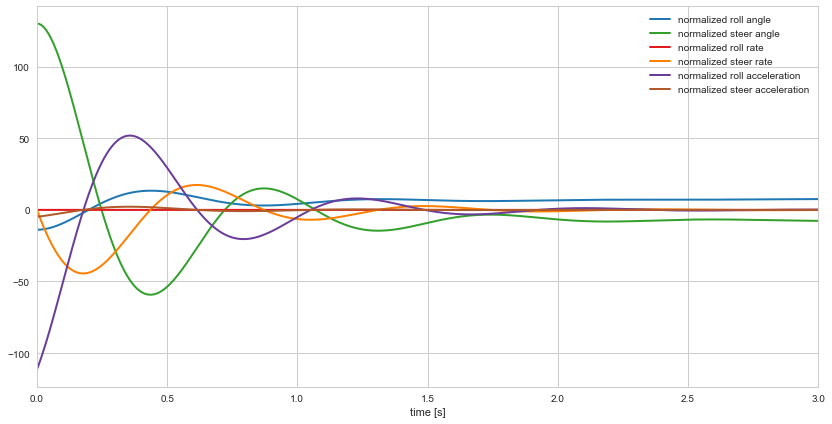

In [6]:
# compare "normalized" state values
y = np.vstack((x, accel))
normalization_constants = np.array([
    K[0, 0], K[0, 1], C[0, 0], C[0, 1], M[0, 0], M[0, 1]
]).reshape((6, 1))
yy = normalization_constants * y
fig4, ax4 = plt.subplots(figsize=figsize)
ax4.plot(t, yy[0, :],
         label='normalized roll angle',
         color=colors[1], linewidth=lw)
ax4.plot(t, yy[1, :],
         label='normalized steer angle',
         color=colors[3], linewidth=lw)
ax4.plot(t, yy[2, :],
         label='normalized roll rate',
         color=colors[5], linewidth=lw)
ax4.plot(t, yy[3, :],
         label='normalized steer rate',
         color=colors[7], linewidth=lw)
ax4.plot(t, yy[4, :],
         label='normalized roll acceleration',
         color=colors[9], linewidth=lw)
ax4.plot(t, yy[5, :],
         label='normalized steer acceleration',
         color=colors[11], linewidth=lw)
ax4.legend()
ax4.set_xlabel('time [s]')
ax4.set_xlim(0, max(t))

In [7]:
# simulate system with roll acceleration term missing from feedback
M = np.zeros((6, 6))
M[:4, :4] = A
M[:4, 4:] = B
M *= dt

Md = scipy.linalg.expm(M)
Md_zero = Md[4:, :4]
Md_eye = Md[4:, 4:]
if not np.array_equal(Md_zero, np.zeros(Md_zero.shape)):
    print('WARNING: Failure in system discretization')
    print(Md_zero)
    print('should equal 0')
if not np.array_equal(Md_eye, np.eye(2)):
    print('WARNING: Failure in system discretization')
    print(Md_eye)
    print('should equal I')
Ad = Md[:4, :4]
Bd = Md[:4, 4:]

def plot_torque_delay(delay):
    torque_buffer = [0] * delay # loop delay in applied torque
    
    xi = x0
    x2 = np.zeros((4, n))
    for i in range(n):
        dx = np.dot(A, xi)
        T_M = -(M[1, 0]*dx[2, 0] +
                C[1, 0]*xi[2, 0] +
                C[1, 1]*xi[3, 0] +
                K[1, 0]*xi[0, 0] +
                K[1, 1]*xi[1, 0])
        torque_buffer.insert(0, T_M)
        applied_torque = torque_buffer.pop()
        
        a = applied_torque - T_M
        u = np.array([0, a]).reshape((2, 1))
        x2[:, i:i+1] = np.dot(Ad, xi) + np.dot(Bd, u)
        xi = x2[:, i:i+1]
    x2 = np.hstack((x0, x2))
    
    fig, ax = plt.subplots(4, 1, sharex=True, figsize=figsize)
    for i, axi in enumerate(ax):
        axi.plot(t, 180/np.pi * x2[i, :],
                 label=labels[i],
                 color=colors[2*i + 1], linewidth=lw)
        axi.set_ylabel(ylabels[i])
        axi.legend()
    ax[-1].set_xlabel('time [s]')
    ax[0].set_xlim(0, max(t))
    return fig, ax

(<matplotlib.figure.Figure at 0x11e2400f0>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x11e418240>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x11ef28908>], dtype=object))

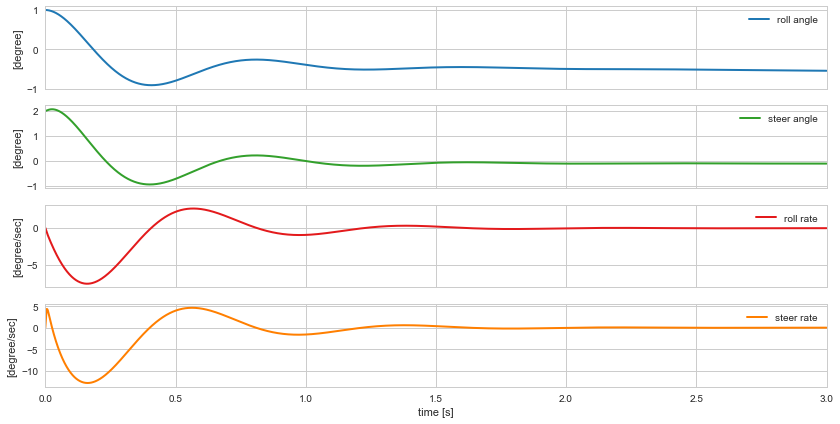

In [8]:
plot_torque_delay(5)

(<matplotlib.figure.Figure at 0x11e718860>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x11efdadd8>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x11f24dcc0>], dtype=object))

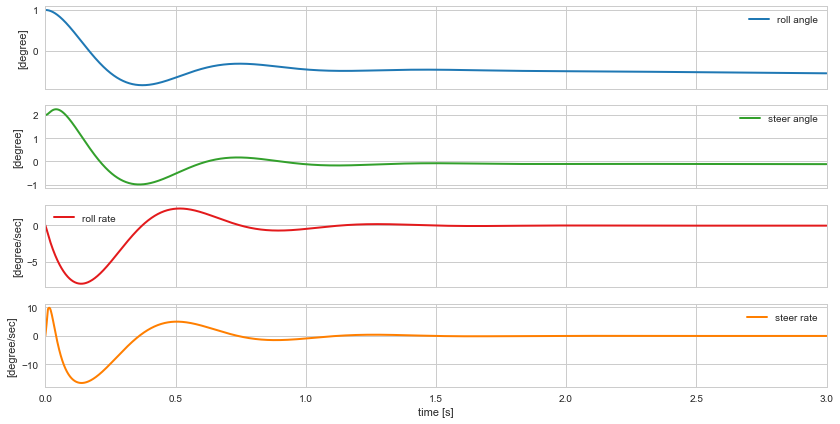

In [9]:
plot_torque_delay(10)

(<matplotlib.figure.Figure at 0x11efa1d68>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x11f332438>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x11f581320>], dtype=object))

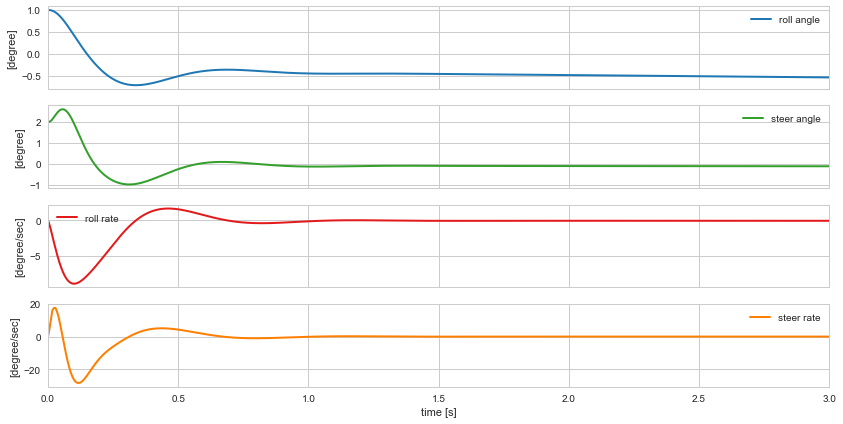

In [10]:
plot_torque_delay(15)

(<matplotlib.figure.Figure at 0x11f32b828>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x11f5dbe10>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x11f88e7f0>], dtype=object))

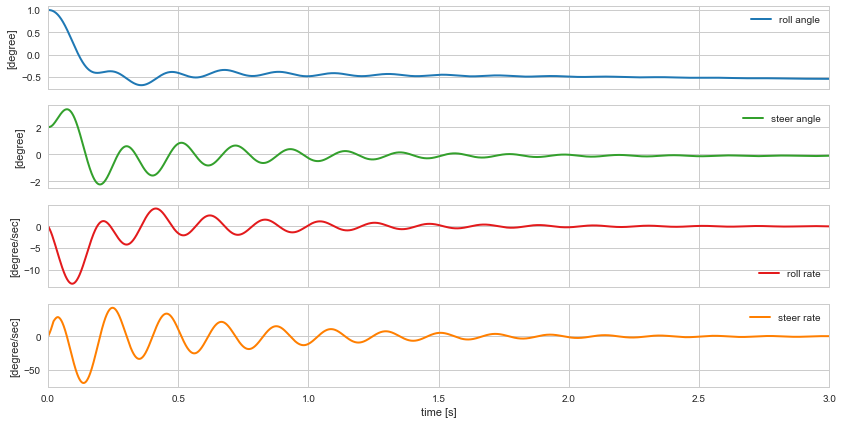

In [11]:
plot_torque_delay(20)

(<matplotlib.figure.Figure at 0x11e739a20>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x11f91d668>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x11fbcdd30>], dtype=object))

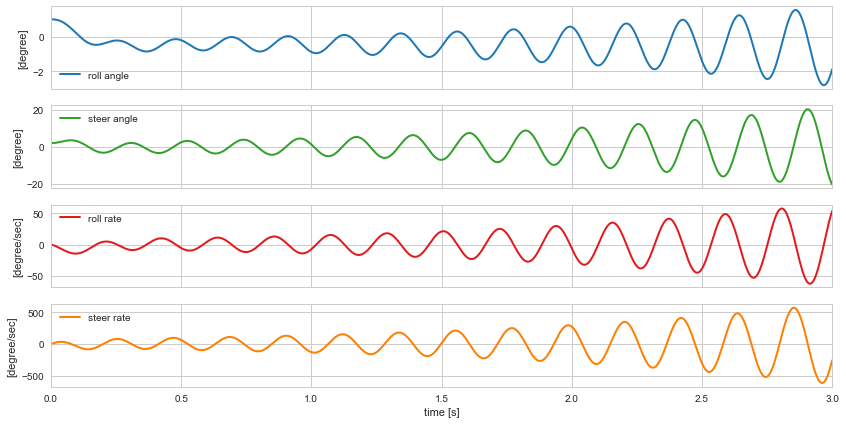

In [12]:
plot_torque_delay(21)